# Data Mining Project - Data Understanding

### Imports and Datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns
import math

In [2]:
account = pd.read_csv('../data/account.csv',delimiter=';')
card_dev = pd.read_csv('../data/card_dev.csv',delimiter=';')
client = pd.read_csv('../data/client.csv',delimiter=';')
disp = pd.read_csv('../data/disp.csv',delimiter=';')
district = pd.read_csv('../data/district.csv',delimiter=';')
loan_dev = pd.read_csv('../data/loan_dev.csv',delimiter=';')
trans_dev = pd.read_csv('../data/trans_dev.csv',delimiter=';', dtype={'bank': str})

### Build Dataset

In [ ]:
def parse_date(date):
  year = int(str(date)[0:2])
  month = int(str(date)[2:4])
  day = int(str(date)[4:6])
  return { 'year': year, 'month': month, 'day': day }


def parse_gender(row, birth_date):
  female = birth_date['month'] >= 50

  if female:
    row['gender'] = 'female' 
    birth_date['month'] -= 50
  else:
    row['gender'] = 'male' 


def calculate_age_loan(row):
  date_loan = row['date_loan']
  birth_number = row['birth_number']

  birth_date = parse_date(birth_number)

  parse_gender(row, birth_date)
  
  if (date_loan is None):
    date_loan = parse_date(row['date_loan'])
    date_loan = date_loan['year'] - birth_date['year'] - ((date_loan['month'], date_loan['day']) < (birth_date['month'], birth_date['day']))
  
  row['age_loan'] = date_loan
    
  return row

The mean for the unemployment rate and the total number of offenses committed are calculated in the following two cells of code.

Any missing value is set to the value of the column whose value is present, e.g. if the value for the "unemploymant rate '95" is not present in a certain row, it is set to the "unemploymant rate '96" value.

The reasoning behind this strategy was that, when taken into account over the course of just one year, neither the unemployment rate nor the number of crimes would be significant. 

In [ ]:
def nan_unemployment_rate(year): return district["unemploymant rate '" + str(year) + " "].isna()

# convert '?' to NaN

district['unemploymant rate \'95 '] = pd.to_numeric(district['unemploymant rate \'95 '], errors='coerce')
district['unemploymant rate \'96 '] = pd.to_numeric(district['unemploymant rate \'96 '], errors='coerce')

# NaN values will be equaled to the value of the other column

district.loc[nan_unemployment_rate(95), 'unemploymant rate \'95 '] = district['unemploymant rate \'96 ']
district.loc[nan_unemployment_rate(96), 'unemploymant rate \'96 '] = district['unemploymant rate \'95 ']

# create column with mean from both years and drop previous and now useless columns

district['unemployment_rate'] = district[['unemploymant rate \'95 ', 'unemploymant rate \'96 ']].mean(axis=1)
district = district.drop(['unemploymant rate \'95 ', 'unemploymant rate \'96 '], axis= 1).reset_index()

In [ ]:
def nan_commited_crimes(year): return district["no. of commited crimes '" + str(year) + " "].isna()

# convert '?' to NaN

district['no. of commited crimes \'95 '] = pd.to_numeric(district['no. of commited crimes \'95 '], errors='coerce')
district['no. of commited crimes \'96 '] = pd.to_numeric(district['no. of commited crimes \'96 '], errors='coerce')

# NaN values will be equaled to the value of the other column

district.loc[nan_commited_crimes(95), 'no. of commited crimes \'95 '] = district['no. of commited crimes \'96 ']
district.loc[nan_commited_crimes(96), 'no. of commited crimes \'96 '] = district['no. of commited crimes \'95 ']

# create column with mean from both years and drop previous and now useless columns

district['commited_crimes'] = district[['no. of commited crimes \'95 ', 'no. of commited crimes \'96 ']].mean(axis=1)
district = district.drop(['no. of commited crimes \'95 ', 'no. of commited crimes \'96 '], axis= 1).reset_index() 

In [ ]:
# join account, loan, disposition and client
df = account.merge(loan_dev, on='account_id', suffixes=('','_loan'), how='right')
df = df.merge(disp, on='account_id', suffixes=('','_disp'), how='left')
df = df.merge(client, on='client_id',suffixes=('','_client'), how='left')

df.drop(columns='district_id', axis=1, inplace=True)

# create age_at_loan and gender column
df = df.apply(lambda row: calculate_age_loan(row), axis=1)

# join demograph
district.rename(columns={'code ':'code'}, inplace=True)
df = df.merge(district, left_on='district_id_client', right_on='code', how='left')

# join creditcard
df = df.merge(card_dev, on='disp_id', suffixes=('', '_card'), how='left')

# join transactions
df_transactions = account.merge(loan_dev, on='account_id', suffixes=('','_loan'), how='right').merge(trans_dev, on='account_id', suffixes=('', '_transaction'), how='left')
df

,account_id,frequency,date,loan_id,date_loan,amount,duration,payments,status,disp_id,...,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,no. of enterpreneurs per 1000 inhabitants,unemploymant_rate,commited_crimes,card_id,type_card,issued
0,1787,weekly issuance,930322,5314,930705,96396,12,8033,-1,2166,...,2,10,81.8,9650,100,3.525,2894.5,NaN,NaN,NaN
1,1801,monthly issuance,930213,5316,930711,165960,36,4610,1,2181,...,3,10,73.5,8369,117,2.050,2736.0,NaN,NaN,NaN
2,9188,monthly issuance,930208,6863,930728,127080,60,2118,1,11006,...,1,5,53.5,8390,132,2.585,2101.0,NaN,NaN,NaN
3,1843,monthly issuance,930130,5325,930803,105804,36,2939,1,2235,...,1,9,74.8,10045,135,1.565,6449.5,NaN,NaN,NaN
4,11013,weekly issuance,930214,7240,930906,274740,60,4579,1,13231,...,1,5,50.5,8288,110,4.155,1511.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,9030,monthly issuance,950121,6818,961212,155616,48,3242,1,10814,...,4,4,62.6,8994,110,4.295,9440.0,NaN,NaN,NaN
399,3189,monthly issuance,951129,5625,961215,222180,60,3703,-1,3855,...,1,6,55.6,8843,113,3.210,853.0,NaN,NaN,NaN
400,8972,monthly issuance,960521,6805,961221,45024,48,938,1,10742,...,5,7,89.9,10177,81,7.190,9993.0,NaN,NaN,NaN
401,10963,monthly issuance,950520,7233,961225,115812,36,3217,1,13172,...,1,8,56.9,8427,107,1.330,1893.5,NaN,NaN,NaN


### Exploratory Analysis

- analise de dados sem graficos
- graficos de dispersao
- bitmaps, coordenadas paralelas
- ver varios atributos ao mm tempo
- matrizes de correlaçao
- graficos de dispersao

##### **Dataframes General Information**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403 entries, 0 to 402
Data columns (total 35 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   account_id                                         403 non-null    int64  
 1   frequency                                          403 non-null    object 
 2   date                                               403 non-null    int64  
 3   loan_id                                            403 non-null    int64  
 4   date_loan                                          403 non-null    int64  
 5   amount                                             403 non-null    int64  
 6   duration                                           403 non-null    int64  
 7   payments                                           403 non-null    int64  
 8   status                                             403 non-null    int64  
 9   disp_id   

In [ ]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24494 entries, 0 to 24493
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   account_id          24494 non-null  int64  
 1   district_id         24494 non-null  int64  
 2   frequency           24494 non-null  object 
 3   date                24494 non-null  int64  
 4   loan_id             24494 non-null  int64  
 5   date_loan           24494 non-null  int64  
 6   amount              24494 non-null  int64  
 7   duration            24494 non-null  int64  
 8   payments            24494 non-null  int64  
 9   status              24494 non-null  int64  
 10  trans_id            24494 non-null  int64  
 11  date_transaction    24494 non-null  int64  
 12  type                24494 non-null  object 
 13  operation           20163 non-null  object 
 14  amount_transaction  24494 non-null  float64
 15  balance             24494 non-null  float64
 16  k_sy

##### **Null values and what to do with them**

In [ ]:
print('CHECKING WITH NULL VALUES IN DF')

df.isna().sum(axis=0)

CHECKING WITH NULL VALUES IN DF


account_id                                             0
frequency                                              0
date                                                   0
loan_id                                                0
date_loan                                              0
amount                                                 0
duration                                               0
payments                                               0
status                                                 0
disp_id                                                0
client_id                                              0
type                                                   0
birth_number                                           0
district_id_client                                     0
gender                                                 0
age_loan                                               0
level_0                                                0
index                          

- discutir sobre a quantidade de null values, se é uma quantidade significativa ou não, como lidar com eles, etc

In [ ]:
print('CHECKING FOR NULL VALUES IN DF_TRANSACTIONS')

df_transactions.isna().sum(axis=0)

CHECKING FOR NULL VALUES IN DF_TRANSACTIONS


account_id                0
district_id               0
frequency                 0
date                      0
loan_id                   0
date_loan                 0
amount                    0
duration                  0
payments                  0
status                    0
trans_id                  0
date_transaction          0
type                      0
operation              4331
amount_transaction        0
balance                   0
k_symbol              14453
bank                  20322
account               17654
dtype: int64

- discutir sobre a quantidade de null values, se é uma quantidade significativa ou não, como lidar com eles, etc

##### **Main Statistics**

In [ ]:
print('STATISTICS FOR SOME OF THE RELEVANT NUMERICAL FEATURES')

# most of the columns, such as the ones with IDs, are irrelevant for this type of analysis
relevant_cols = [
    'amount',
    'duration',
    'payments',
    'age_loan',
    'average salary ',
    'ratio of urban inhabitants ',
    'unemploymant_rate',
    'unemploymant_rate',
]
df[relevant_cols].describe()

STATISTICS FOR SOME OF THE RELEVANT NUMERICAL FEATURES


,amount,duration,payments,age_loan,average salary,ratio of urban inhabitants,unemploymant_rate,unemploymant_rate
count,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000
mean,147453.558313,36.148883,4190.367246,950147.595533,9513.744417,67.773449,3.194615,3.194615
std,106720.070532,16.768178,2215.606456,9421.810940,1327.263813,20.292260,2.038483,2.038483
min,4980.000000,12.000000,319.000000,930705.000000,8110.000000,33.900000,0.360000,0.360000
25%,71460.000000,24.000000,2468.000000,940817.000000,8544.000000,52.700000,1.770000,1.770000
50%,113796.000000,36.000000,3900.000000,950613.000000,8991.000000,61.900000,3.015000,3.015000
75%,200328.000000,48.000000,6003.000000,960603.000000,9897.000000,85.500000,4.295000,4.295000
max,538500.000000,60.000000,9689.000000,961227.000000,12541.000000,100.000000,8.370000,8.370000


- verificar a existência de outliers
    - existem? como lidar com eles (eliminar, normalizar de alguma maneira, etc)?

In [ ]:
print('STATISTICS FOR THE NON-NUMERICAL FEATURES')

df.describe(include=['object'])

STATISTICS FOR THE NON-NUMERICAL FEATURES


,frequency,type,gender,name,region,type_card
count,403,403,403,403,403,11
unique,3,2,2,73,8,3
top,monthly issuance,OWNER,male,Hl.m. Praha,south Moravia,classic
freq,322,328,207,51,87,8


- verificar a existência de outliers
    - existem? como lidar com eles (eliminar, normalizar de alguma maneira, etc)?

##### **Target Distribution and Correlation Matrix**

Text(0.5, 1.0, 'Status count for bank loans')

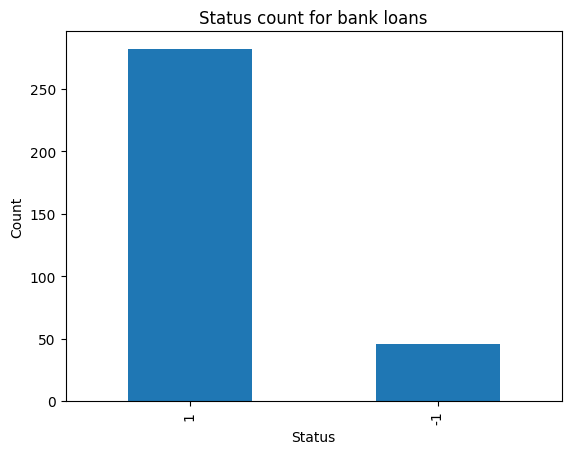

In [ ]:
loan_dev['status'].value_counts().plot.bar()
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Status count for bank loans')

/tmp/ipykernel_211295/2736954336.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


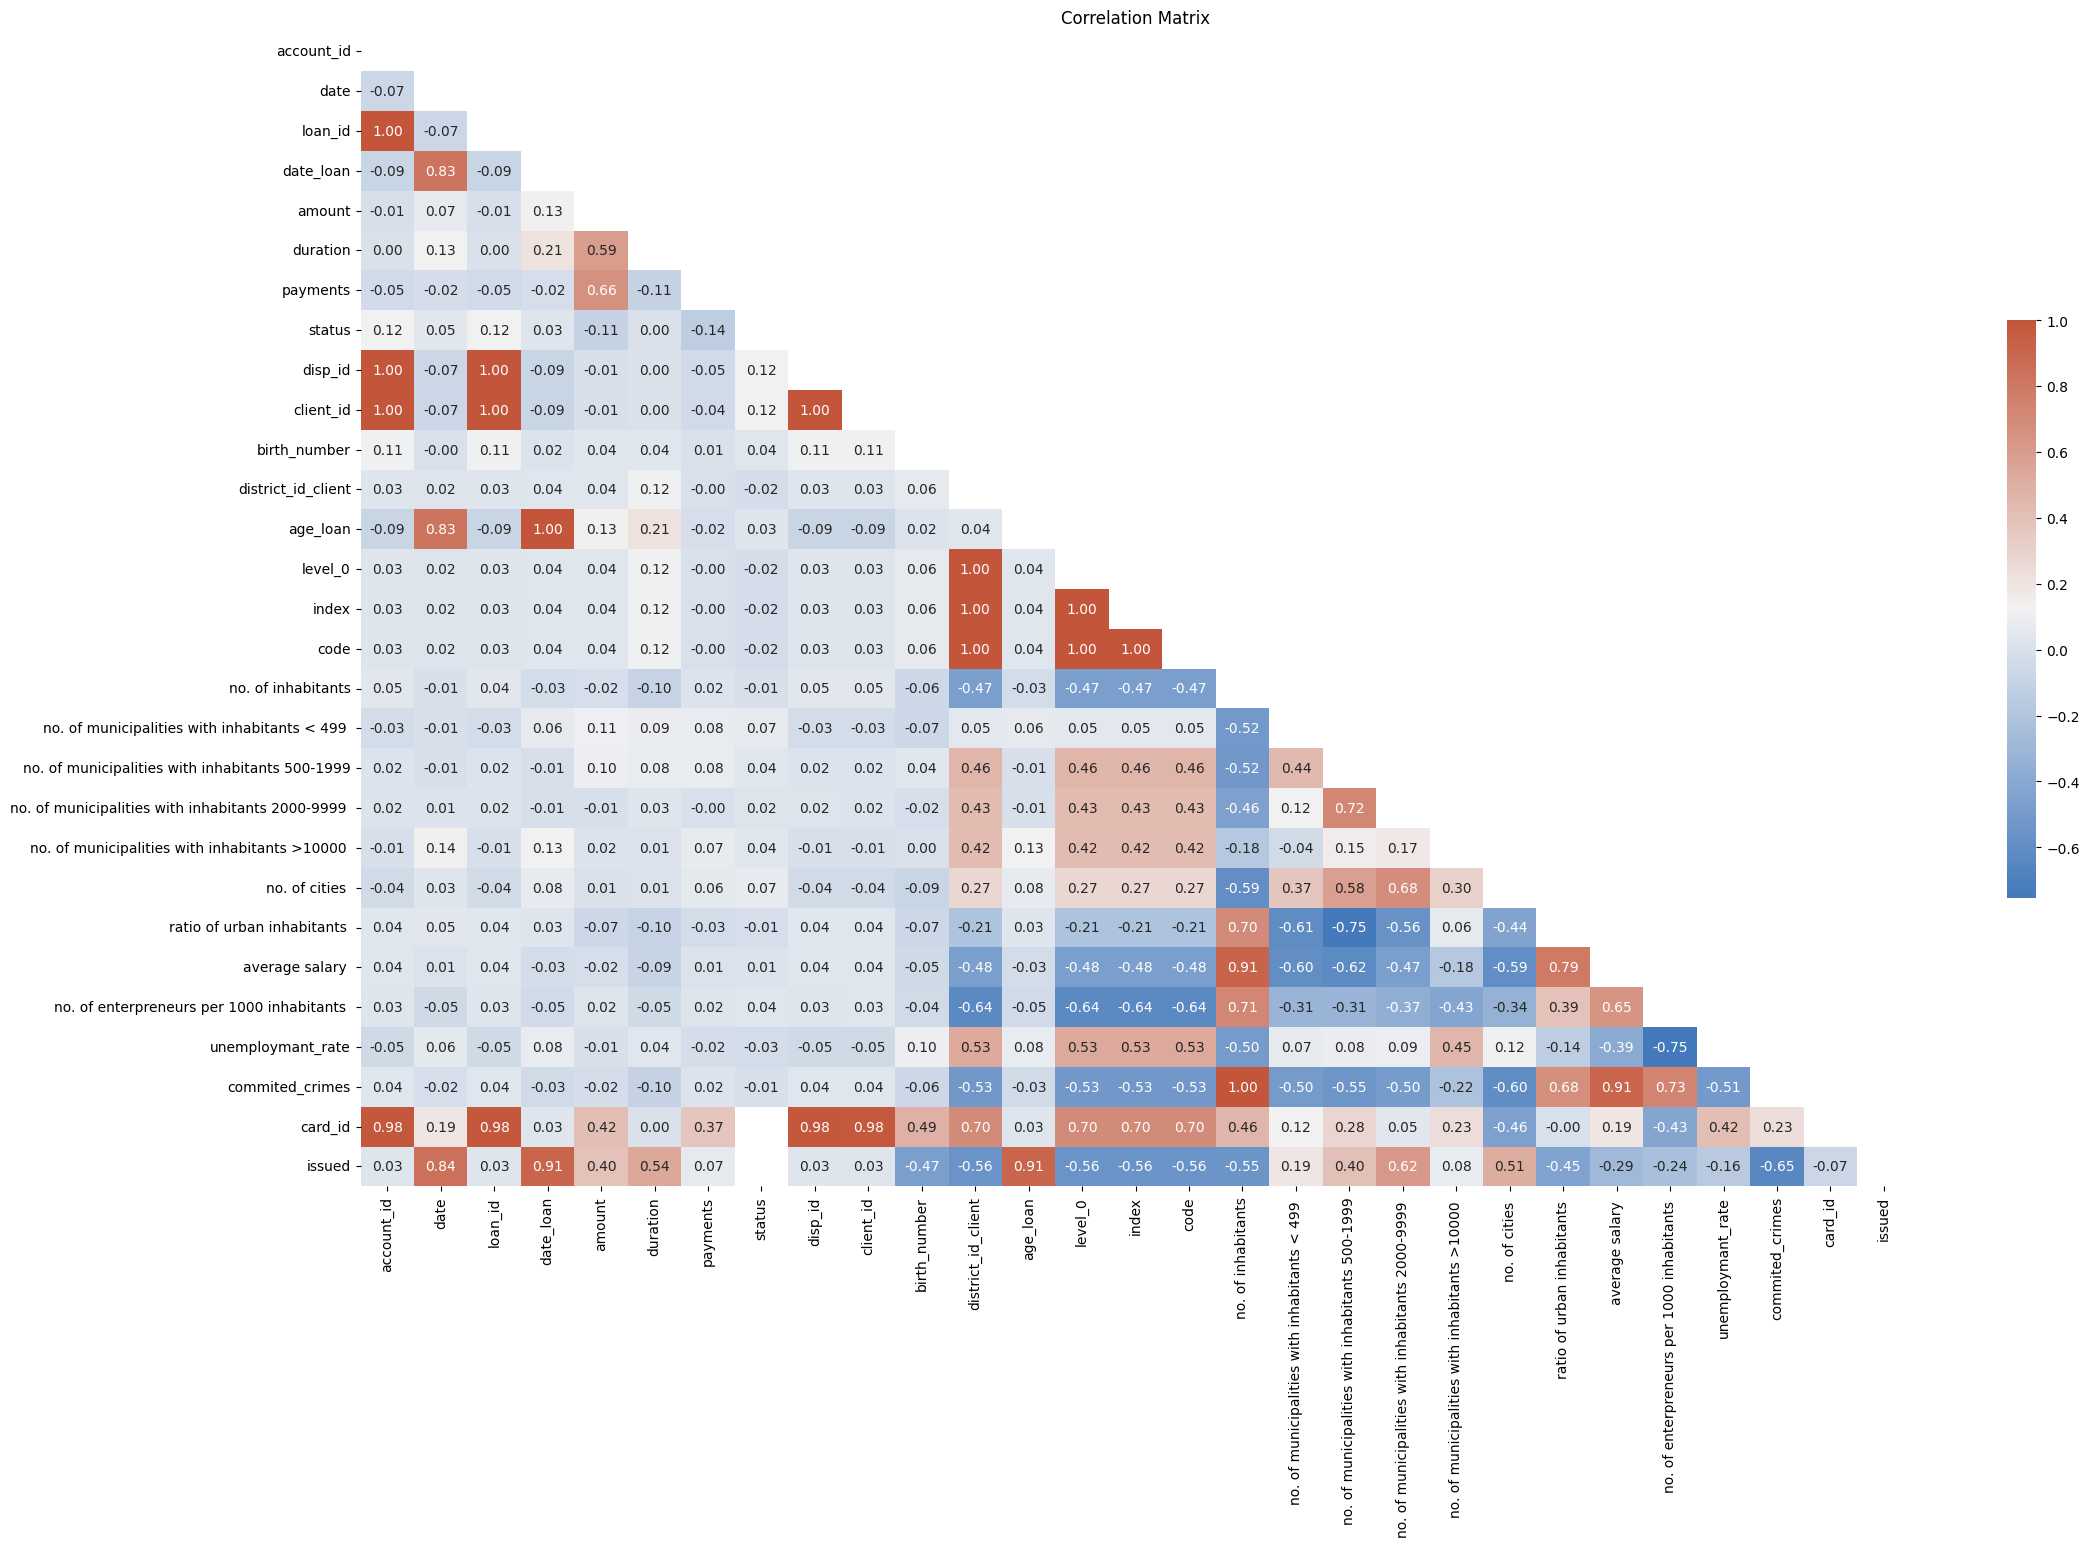

In [ ]:
# correlation analysis

corr = df.corr()
mask = np.triu(corr)

fig = plt.figure(figsize=(25,15))

colormap = sns.diverging_palette(250, 20, as_cmap=True)
sns.heatmap(
    corr, 
    annot=True, 
    fmt='.2f',
    cbar_kws={'shrink': .5},
    mask=mask,
    cmap=colormap).set(title='Correlation Matrix')

plt.show()

##### **Demographic Data Distribution per Status**

/tmp/ipykernel_211295/2956769955.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


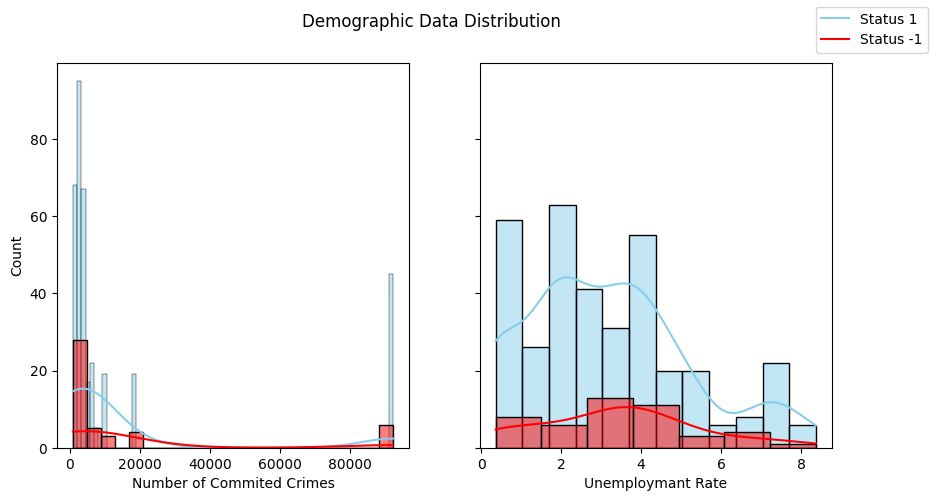

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)

# commited crimes
sns.histplot(data=df[df['status'] == 1], x='commited_crimes', color="skyblue", kde=True, ax=axs[0])
sns.histplot(data=df[df['status'] == -1], x='commited_crimes', color="red", kde=True, ax=axs[0])

# unemplyment rate
sns.histplot(data=df[df['status'] == 1], x='unemploymant_rate', color="skyblue", kde=True, ax=axs[1])
sns.histplot(data=df[df['status'] == -1], x='unemploymant_rate', color="red", kde=True, ax=axs[1])

axs[0].set_xlabel('Number of Commited Crimes')
axs[1].set_xlabel('Unemploymant Rate')

fig.suptitle('Demographic Data Distribution')
fig.legend(['Status 1', 'Status -1'])
fig.show()

##### **Number of Account Disponents - Statistics and Distribution per Status**

In [ ]:
# number of disponents of each account
disp_count = df.groupby(['account_id'])['disp_id'].nunique() 

df = df.merge(disp_count, on='account_id', suffixes=('', '_count'), how='left')

In [ ]:
df['disp_id_count'].describe()

count    403.000000
mean       1.372208
std        0.483994
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: disp_id_count, dtype: float64

Text(0.5, 1.0, 'Status count by number of account disponents')

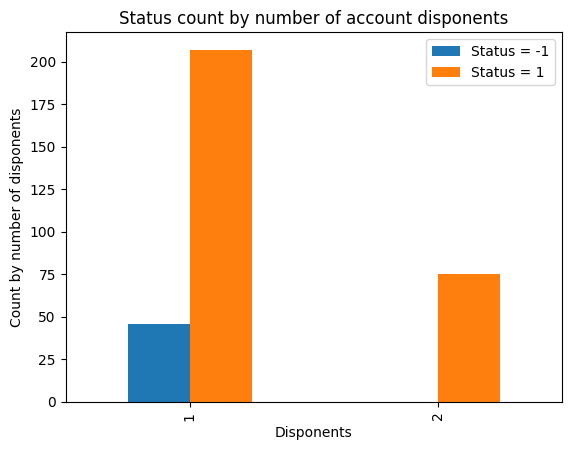

In [ ]:
no_dups_df = df.drop_duplicates(subset=['account_id']) #remove duplicates
no_dups_df.groupby('disp_id_count')['status'].value_counts().unstack(1).plot.bar()

plt.xlabel('Disponents')
plt.ylabel('Count by number of disponents')
plt.legend(['Status = -1', 'Status = 1'])
plt.title('Status count by number of account disponents')

##### **Difference between the Average Salary and each Loan Installment - Statistics and Distribution per Status**

In [ ]:
df['diff_salary_loan'] = df['average salary '] - df['payments']

In [ ]:
df['diff_salary_loan'].describe()

count      403.000000
mean      5323.377171
std       2573.716637
min      -1177.000000
25%       3425.500000
50%       5474.000000
75%       6952.000000
max      12052.000000
Name: diff_salary_loan, dtype: float64

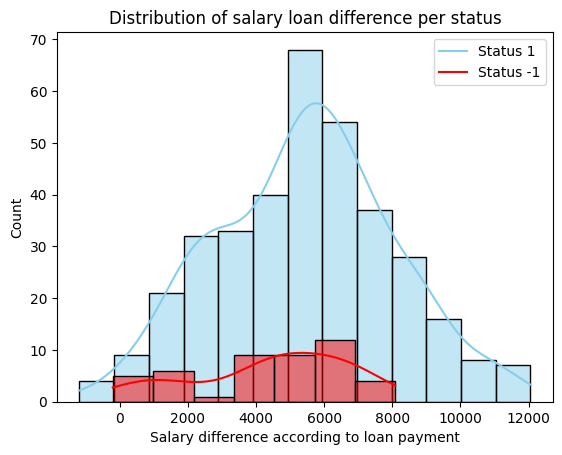

In [ ]:
sns.histplot(data=df[df['status'] == 1], x='diff_salary_loan', color="skyblue", kde=True)
sns.histplot(data=df[df['status'] == -1], x='diff_salary_loan', color="red", kde=True)

plt.xlabel('Salary difference according to loan payment')
plt.legend(['Status 1', 'Status -1'])
plt.title('Distribution of salary loan difference per status')
plt.show()

##### **Analysis of the Gender Impact on the Loan Status**

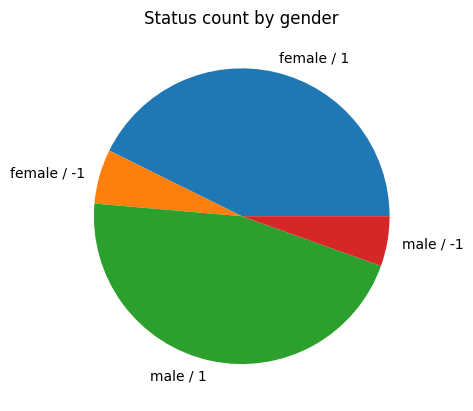

In [ ]:
values = np.array(df.groupby('gender')['status'].value_counts())
labels = ['female / 1', 'female / -1', 'male / 1', 'male / -1']

plt.pie(values, labels=labels)
plt.title('Status count by gender')
plt.show()

In [ ]:
transaction_count = df_transactions.groupby(['account_id'])['trans_id'].nunique()

df_transactions = df_transactions.merge(transaction_count, on='account_id', suffixes=['_', '_count'], how='left')

##### **Statistics for Other Relevant Features and Outliers Detection**

In [ ]:
count_transactions_per_type = df_transactions.groupby(['account_id', 'type']).size().unstack(fill_value=0)
count_transactions_per_type['debit'] = count_transactions_per_type['withdrawal'] + count_transactions_per_type['withdrawal in cash']
count_transactions_per_type.drop(labels=['withdrawal', 'withdrawal in cash'], axis=1, inplace=True)
count_transactions_per_type['credit_debit_ratio'] = count_transactions_per_type['credit'] / count_transactions_per_type['debit']

df_transactions = df_transactions.merge(count_transactions_per_type, on='account_id', how='left')
df_transactions.replace([np.inf, -np.inf], 0, inplace=True)
df_transactions.rename({ 
    'trans_id_count': 'transactions_count', 
    'credit': 'credits_count', 
    'debit': 'debits_count' }, 
    axis=1, inplace=True)


In [ ]:
df_transactions.columns

Index(['account_id', 'district_id', 'frequency', 'date', 'loan_id',
       'date_loan', 'amount', 'duration', 'payments', 'status', 'trans_id_',
       'date_transaction', 'type', 'operation', 'amount_transaction',
       'balance', 'k_symbol', 'bank', 'account', 'transactions_count',
       'credits_count', 'debits_count', 'credit_debit_ratio'],
      dtype='object')

<AxesSubplot: title={'center': 'duration'}, xlabel='status'>

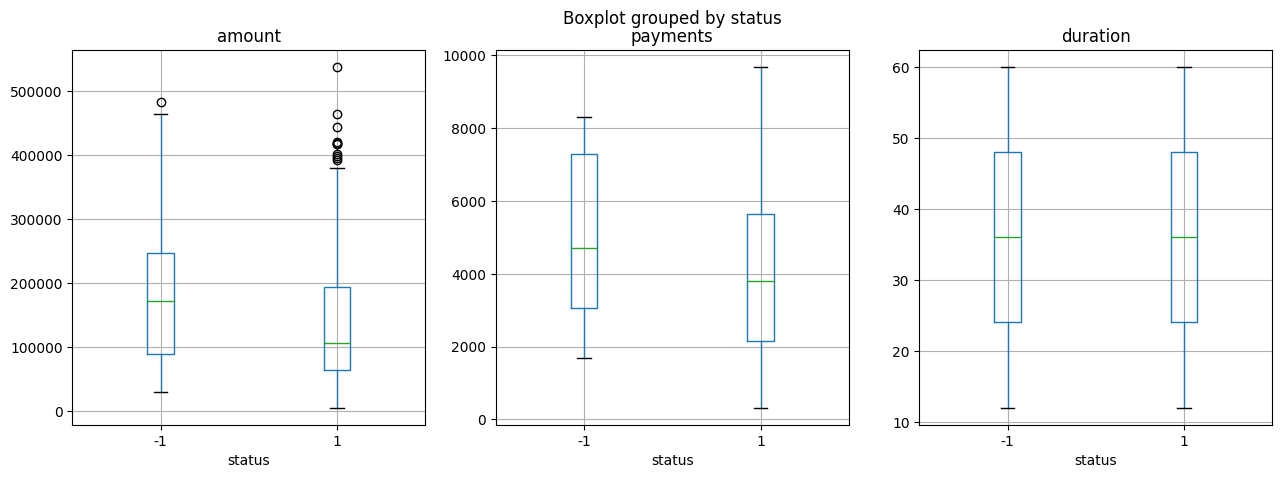

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

loan_dev.boxplot(column='amount', by='status', figsize=(5,5), ax=axs[0])
loan_dev.boxplot(column='payments', by='status', figsize=(5,5), ax=axs[1])
loan_dev.boxplot(column='duration', by='status', figsize=(5,5), ax=axs[2])

<AxesSubplot: title={'center': 'diff_salary_loan'}, xlabel='status'>

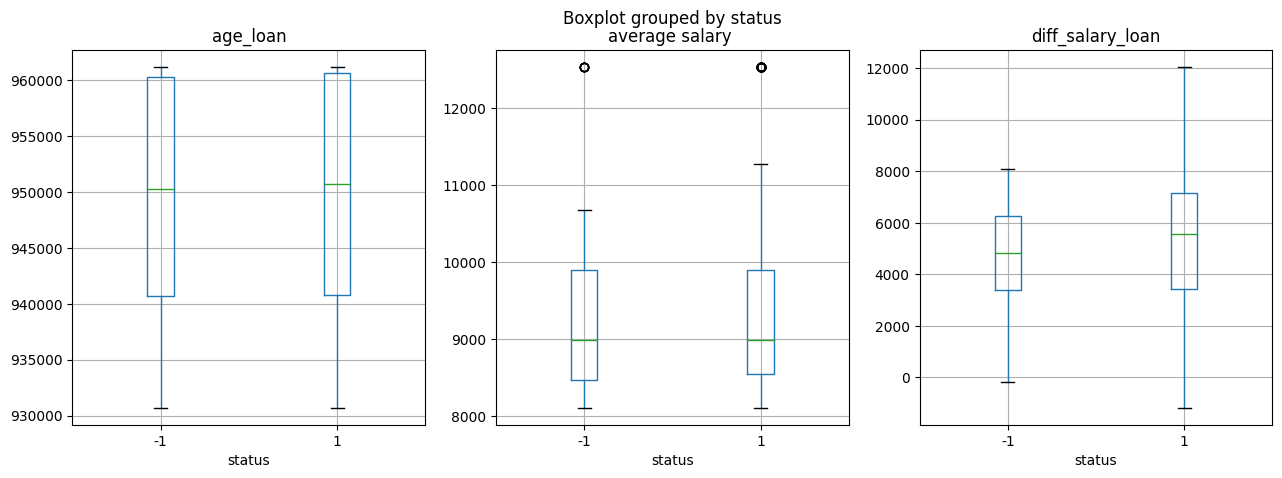

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

df.boxplot(column='age_loan', by='status', figsize=(5,5), ax=axs[0])
df.boxplot(column='average salary ', by='status', figsize=(5,5), ax=axs[1])
df.boxplot(column='diff_salary_loan', by='status', figsize=(5,5), ax=axs[2])

<AxesSubplot: title={'center': 'credit_debit_ratio'}, xlabel='status'>

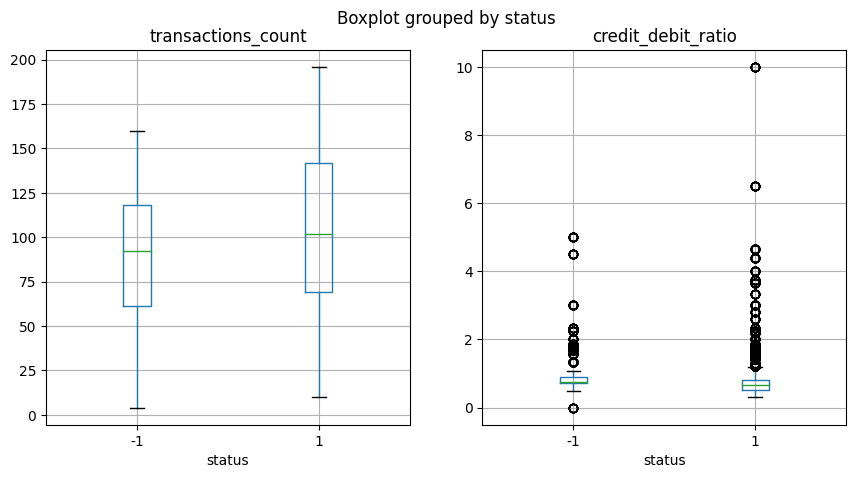

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

df_transactions.boxplot(column='transactions_count', by='status', figsize=(5,5), ax=axs[0])
df_transactions.boxplot(column='credit_debit_ratio', by='status', figsize=(5,5), ax=axs[1])